In [3]:
import torch
import torch_dct as dct
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import StepLR

import matplotlib.pyplot as plt
plt.style.use(['science','no-latex', 'notebook'])

from multiprocessing import Pool, Queue, Process, set_start_method
import multiprocessing as mp_

import time
import pkbar
import sys
sys.path.append('../')
from common import *
from transform_based_network import *

In [4]:
class T_Layer(nn.Module):
    def __init__(self, dct_w, dct_b):
        super(T_Layer, self).__init__()
        self.weights = nn.Parameter(dct_w)
        self.bias = nn.Parameter(dct_b)
        
    def forward(self, dct_x):
        x = torch.mm(self.weights, dct_x) + self.bias
        return x

    
class Frontal_Slice(nn.Module):
    def __init__(self, dct_w, dct_b):
        super(Frontal_Slice, self).__init__()
        self.device = dct_w.device
        self.dct_linear = T_Layer(dct_w, dct_b)
        self.linear1 = nn.Linear(28, 28)
        self.linear2 = nn.Linear(28, 28)
        self.classifier = nn.Linear(28, 10)
        
    def forward(self, x):
        x = torch.transpose(x, 0, 1).to(self.device)
        x = self.dct_linear(x)
        #x = self.linear1(x)
        #x = self.linear2(x)
        x = self.classifier(x)
        x = torch.transpose(x, 0, 1)
        return x
    
    
class Ensemble(nn.Module):
    def __init__(self, shape, device='cpu'):
        super(Ensemble, self).__init__()
        self.device = device    
        self.models = []
        for i in range(shape[0]):
            dct_w, dct_b = make_weights(shape, device, scale=0.01)
            model = Frontal_Slice(dct_w[i, ...], dct_b[i, ...])
            self.models.append(model.to(device))
        
    def forward(self, x):
        result = torch.empty(x.shape[0], 10, x.shape[2])
        dct_x = torch_apply(dct.dct, x).to(self.device)
        for i in range(len(self.models)):
            result[i, ...] = self.models[i](dct_x[i, ...])
        result = torch_apply(dct.idct, result)
        softmax = scalar_tubal_func(result)
        return torch.transpose(softmax, 0, 1)

In [5]:
def train_ensemble(x, y, i=50, device='cuda:0'):
    x = torch_shift(x).to(device)
    y = y.to(device)
    ensemble = Ensemble(x.shape, device).to(device)
    params = []
    for m in ensemble.models:
        params += list(m.parameters())
    optimizer = optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()
    pbar = pkbar.Pbar(name='progress', target=i)
    for j in range(i):
        outputs = ensemble(x)
        optimizer.zero_grad()
        loss = criterion(outputs.to(device), y)
        loss.backward()
        optimizer.step()
        pbar.update(j)
        
    print(loss.item())
    return ensemble

## 16, 10, 10, 100 iterations
# cpu, for loop: 4.1s
# gpu, for loop: 5.5s

In [13]:
x0 = []
y0 = []
for i in range(100):
    x0.append(torch.randn(16, 29, 28))
    y0.append(torch.randint(10, (16,)))

for i in range(100):
    train_ensemble(x0[i], y0[i], i=1, device='cpu')

progress
1/1  [==============================] - 0.1s
2.258345127105713
progress
1/1  [==============================] - 0.1s
2.2054741382598877
progress
1/1  [==============================] - 0.1s
2.2106308937072754
progress
1/1  [==============================] - 0.1s
2.3958640098571777
progress
1/1  [==============================] - 0.1s
2.396796226501465
progress
1/1  [==============================] - 0.1s
2.3846657276153564
progress
1/1  [==============================] - 0.1s
2.377892255783081
progress
1/1  [==============================] - 0.1s
2.333148956298828
progress
1/1  [==============================] - 0.1s
2.382307529449463
progress
1/1  [==============================] - 0.1s
2.353180170059204
progress
1/1  [==============================] - 0.1s
2.226315975189209
progress
1/1  [==============================] - 0.1s
2.43098783493042
progress
1/1  [==============================] - 0.1s
2.294565200805664
progress
1/1  [==============================] - 0.1s
2.29696

In [7]:
train_ensemble(x, y, i=20, device='cpu')

NameError: name 'x' is not defined

In [8]:
def train_slice(model, x_i, y_i):
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.5, momentum=0.9, weight_decay=5e-4)
    outputs = model(x_i, 2)
    optimizer.zero_grad()
    loss = criterion(outputs.cuda(), y_i.cuda())
    loss.backward()
    optimizer.step()

In [9]:
batch_size = 50
trainloader, testloader = load_mnist_multiprocess(batch_size)

==> Loading data..


In [10]:
device = 'cpu'
for epoch in range(10):
    pbar = pkbar.Pbar(name='Epoch'+str(epoch), target=60000/batch_size)
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        '''

        dct_x = torch_apply(dct.dct, x.squeeze())
        y_cat = to_categorical(y, 10) 

        dct_y_cat = torch.randn(y_cat.shape[0], dct_x.shape[1], 10)
        for i in range(10):
            dct_y_cat[:, i, :] = y_cat
        dct_y_cat = torch_apply(dct.dct, dct_y_cat)
        dct_x.to(device)
        dct_y_cat.to(device)
        '''

        correct = 0
        train_loss = 0
        total = 0
        inputs = torch_shift(inputs).to(device)
        ensemble = Ensemble(inputs.shape, device).to(device)
        params = []
        
        for m in ensemble.models:
            params += list(m.parameters())
        optimizer = optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=5e-4)
        criterion = nn.CrossEntropyLoss()

        outputs = ensemble(inputs) 
        optimizer.zero_grad()
        loss = criterion(outputs.to(device), targets.to(device))
        loss.backward()
        optimizer.step()
            
        _, predicted = torch.max(outputs, 1)
        correct += predicted.eq(targets).sum().item()
        train_loss += loss.item()
        total += batch_size
        print(loss)
        
        pbar.update(batch_idx)
    print(correct/total, train_loss/total)
    

'''
    models = []
    for i in range(16):
        dct_w, dct_b = make_weights(dct_x.shape, device=device)
        model = Frontal_Slice(dct_w[i, ...], dct_b[i, ...])
        models.append(model.to(device))

    for i in range(len(models)):
        train_slice(models[i], dct_x[i, ...], dct_y_cat[i, ...])
    print()
    pbar.update(batch_idx)
    
    tmp = torch_mp.get_context('spawn')
    for model in models:
        model.share_memory()
    processes = []

    for i in range(len(models)):
        p = tmp.Process(target=train_slice, 
                        args=(models[i], dct_x[i, ...], dct_y_cat[i, ...]))
        p.start()
        processes.append(p)
    for p in processes: 
        p.join()
    '''

Epoch0
tensor(2.9926, grad_fn=<NllLossBackward>)
  64/1200  [>.............................] - 17.1s

KeyboardInterrupt: 

In [92]:
trainloader, testloader = load_mnist_multiprocess(100)

for batch_idx, (inputs, labels) in enumerate(trainloader):   
    x = inputs
    y = labels
    break

==> Loading data..


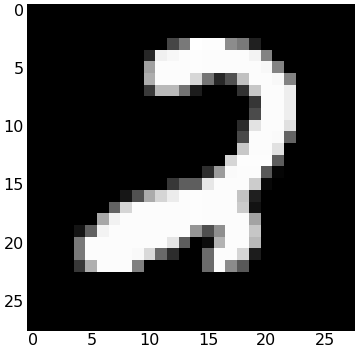

In [93]:
plt.imshow(x[0].reshape((28, 28)), cmap='gray')